#補值

---


1.   cart填補+剩餘800筆NA用均值填補
2.   通通使用均值填補
3. 想用linear填補但直接死機於是放棄




##CART+NA用均值填補

In [1]:
#以cart填值仍會留下約800個NA
#NA部分使用均值填補
import pandas as pd
import numpy as np
data_CART = pd.read_csv('bk_cart.csv')

In [2]:
data_CART.isnull().sum()>0

X                                                          False
Bankrupt.                                                  False
ROA.C..before.interest.and.depreciation.before.interest    False
ROA.A..before.interest.and...after.tax                     False
ROA.B..before.interest.and.depreciation.after.tax          False
                                                           ...  
Liability.to.Equity                                        False
Degree.of.Financial.Leverage..DFL.                         False
Interest.Coverage.Ratio..Interest.expense.to.EBIT.         False
Net.Income.Flag                                             True
Equity.to.Liability                                        False
Length: 97, dtype: bool

In [3]:
for column in list(data_CART.columns[data_CART.isnull().sum() > 0]):
    mean_val = data_CART[column].mean()
    data_CART[column].fillna(mean_val, inplace=True)

##通通使用均值填補

In [4]:
data = pd.read_csv('bankruptcy.csv')

In [5]:
for column in list(data.columns[data.isnull().sum() > 0]):
    mean_val = data[column].mean()
    data[column].fillna(mean_val, inplace=True)

In [56]:
data.to_csv('data.csv')

#運作流程


1.   因為特徵太多,為降低計算量,處理類別問題前先corr在>0.1~<-0.1區間的feature篩選(選出與預測結果高相關的特徵)
2.   **ADASYN處理類別不平衡**
3. 使用logistic,knn,svm,randomforest做為分類預測模型




#cart

In [6]:
#取得corr在特定區間的feature
top15_feature=data_CART.corr()

In [7]:
top15_feature=top15_feature[(top15_feature['Bankrupt.']>0.1) | (top15_feature['Bankrupt.']<-0.1)].index
#使用mice中的cart填值後欄位名稱不同

In [8]:
top15_feature=list(top15_feature)
top15_df = data_CART[top15_feature]

##mean

In [9]:
#取得corr在特定區間的feature
top30_feature=data.corr()

In [10]:
top30_feature=top30_feature[(top30_feature['Bankrupt?']>0.1) | (top30_feature['Bankrupt?']<-0.1)].index

In [11]:
top30_df = data[top30_feature]

#類別不平衡處理 : 合成資料ADASYN

In [12]:
#cart
from collections import Counter
from imblearn.over_sampling import ADASYN
X,y = top15_df.drop(['Bankrupt.'],axis=1),data_CART['Bankrupt.']
print('原始資料分布 : ',Counter(y))

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
ada = ADASYN(random_state=42)
X_ada,y_ada = ada.fit_resample(X,y)
print('ADASYN後資料分布 : ',Counter(y_ada))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


原始資料分布 :  Counter({0: 6599, 1: 220})
ADASYN後資料分布 :  Counter({1: 6628, 0: 6599})


In [13]:
#mean
X_30,y_30 = top30_df.drop(['Bankrupt?'],axis=1),data['Bankrupt?']
print('原始資料分布 : ',Counter(y_30))

X_ada_30,y_ada_30 = ada.fit_resample(X_30,y_30)
print('ADASYN後資料分布 : ',Counter(y_ada_30))

原始資料分布 :  Counter({0: 6599, 1: 220})
ADASYN後資料分布 :  Counter({1: 6660, 0: 6599})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


#特徵選取


---
由於已經使用corr篩選一次,這邊直接用wrapper



In [14]:
#遞歸消除特徵法
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

wrapper_top15=RFE(estimator=LogisticRegression(), n_features_to_select=17).fit_transform(X_ada, y_ada)
wrapper_top15_mean =RFE(estimator=LogisticRegression(), n_features_to_select=16).fit_transform(X_ada_30, y_ada_30)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




1.   cart填補中,有冗員 'Net.Value.Per.Share..B.', 'Net.Value.Per.Share..A.'基本上是一樣的特徵, Liability-Assets Flag幾乎都是0,沒啥意義,於是剔除A,Liability 另外再選兩個( Equity to Long-term Liability ,  Net Income to Total Assets)
2.   均值填補中,剔除'Net.Value.Per.Share..A.',補上 ROA(A) before interest and % after tax



#建模預測 

In [16]:
#Logistic regression分類原理:
#以linear擬和找出可以預測不同資料的參數,使用座標轉換的方式將linear式轉成機率,以機率最大的為分類結果
from sklearn import metrics
from sklearn.metrics import classification_report
X_train,X_test,y_train,y_test = train_test_split(wrapper_top15,y_ada,test_size=0.3)
log = LogisticRegression(solver='liblinear').fit(X_train, y_train)
log_pred = log.predict(X_test)
print('cart+均值填補')
print (metrics.classification_report(y_test,log_pred))
print('均值填補')
X_tra,X_tes,y_tra,y_tes = train_test_split(wrapper_top15_mean,y_ada_30,test_size=0.3)
log_mean = LogisticRegression(solver='liblinear').fit(X_tra, y_tra)
log_predict = log_mean.predict(X_tes)
print (metrics.classification_report(y_tes,log_predict))
#結果看來不管是用cart還是均值填補效果無異

cart+均值填補
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1975
           1       0.83      0.89      0.86      1994

    accuracy                           0.86      3969
   macro avg       0.86      0.85      0.85      3969
weighted avg       0.86      0.86      0.85      3969

均值填補
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1996
           1       0.82      0.88      0.85      1982

    accuracy                           0.84      3978
   macro avg       0.85      0.85      0.84      3978
weighted avg       0.85      0.84      0.84      3978



In [17]:
#KNN分類原理 : 
#1)一般使用歐式距離衡量要預測對象&有標籤的資料距離,
#2)距離排序以前k個近的有標籤資料做出預測
#3)假設k=3,其中有標籤資料中1筆是0類,2筆是1類,判為1類(出現機率高的)
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=1) 
knn.fit(X_train,y_train)
predicted = knn.predict(X_test)
print('cart+均值填補')
print (metrics.classification_report(y_test,predicted))
# 使用ADASYN以密度填值,knn是以歐式距離抓取最近的資料分類,這樣操作有失公允?嗎

print('均值填補') 
knn.fit(X_tra,y_tra)
predicted_mean = knn.predict(X_tes)
print (metrics.classification_report(y_tes,predicted_mean))

cart+均值填補
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1975
           1       0.91      0.99      0.95      1994

    accuracy                           0.95      3969
   macro avg       0.95      0.95      0.95      3969
weighted avg       0.95      0.95      0.95      3969

均值填補
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      1996
           1       0.91      1.00      0.95      1982

    accuracy                           0.95      3978
   macro avg       0.95      0.95      0.95      3978
weighted avg       0.95      0.95      0.95      3978



In [18]:
#SVM分類原理 :
#找到支援向量(support vector,邊緣上的數據點),可以把數據良好分類的超平面與決策邊界(容錯機制)來分類
#目標要使兩側的間隔最大(楚河漢界類別間分得清清楚楚)
#常用參數說明 : c越小,對誤差容忍大,決策邊界大 gamma則是決定任一個支持向量的影響力,gamma越大單一支持向量影響力越大
from sklearn.svm import SVC
svm=SVC(gamma='auto')
svm.fit(X_train,y_train)
predicted = svm.predict(X_test)
print('以cart填補')
print (metrics.classification_report(y_test,predicted))
print('以均值填補')
svm.fit(X_tra,y_tra)
predicted_m = svm.predict(X_tes)
print (metrics.classification_report(y_tes,predicted_m))
#均值填補似乎還略勝一籌,因為填值時更有利1類(相較cart)?
#但似乎比較的類別樣本不同...有失公允?

以cart填補
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      1975
           1       0.81      0.91      0.86      1994

    accuracy                           0.85      3969
   macro avg       0.85      0.85      0.85      3969
weighted avg       0.85      0.85      0.85      3969

以均值填補
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1996
           1       0.80      0.91      0.85      1982

    accuracy                           0.84      3978
   macro avg       0.85      0.84      0.84      3978
weighted avg       0.85      0.84      0.84      3978



要分幾群? elbow point

#非層級分群

##Kmeans

In [19]:
#cart+均值
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=2) 
k_means.fit(X_train) 
print(k_means.labels_[:]) 
print(y_train[:]) 

score = metrics.accuracy_score(y_test,k_means.predict(X_test)) 
print('Accuracy:{0:f}'.format(score)) 


[0 1 1 ... 1 0 0]
[0 1 1 ... 0 1 0]
Accuracy:0.752079


In [20]:
#均值
k_means.fit(X_tra) 
print(k_means.labels_[:]) 
print(y_tra[:]) 

score = metrics.accuracy_score(y_tes,k_means.predict(X_tes)) 
print('Accuracy:{0:f}'.format(score))
#痾 但用均值的準確低 
#均值與cart填補的表現會呈現相反, 為啥 (編號反了?)
#準確又變高ㄌ 我疑惑

[1 0 0 ... 1 1 1]
[1 0 1 ... 0 0 1]
Accuracy:0.851433


In [21]:
#再一次訓練看看結果
score = metrics.accuracy_score(y_test,k_means.predict(X_test)) 
print('Accuracy:{0:f}'.format(score)) 

Accuracy:0.502646


##fuzzy-c-means1


---
fcmeans


In [22]:
!pip install fuzzy-c-means

In [23]:
%matplotlib inline
from fcmeans import FCM
from matplotlib import pyplot as plt
fcm = FCM(n_clusters=2)
fcm.fit(wrapper_top15)

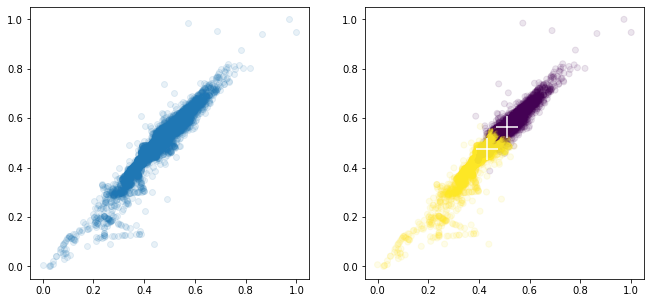

In [24]:
fcm_centers = fcm.centers
fcm_labels = fcm.predict(wrapper_top15)

# plot result(以前二重要特徵作為分群標準)
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(wrapper_top15[:,0], wrapper_top15[:,1], alpha=.1)
axes[1].scatter(wrapper_top15[:,0], wrapper_top15[:,1], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,1], marker="+", s=500, c='w')
plt.savefig('basic-clustering-output.jpg')
plt.show()
#在邊界處有重疊,但也不知道是否分對

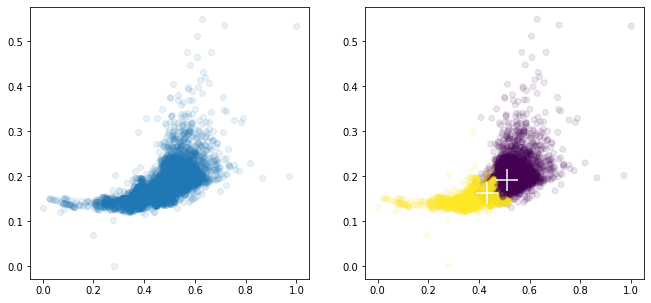

In [25]:
#在wrapper前的前三大corr類別非常相似,於是直接用第一類與第四類作為分類依據
#但使用wrapper處理後的特徵可能已經有所不一樣
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(wrapper_top15[:,0], wrapper_top15[:,3], alpha=.1)
axes[1].scatter(wrapper_top15[:,0], wrapper_top15[:,3], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,0], fcm_centers[:,3], marker="+", s=500, c='w')
# plt.savefig('basic-clustering-output.jpg')
plt.show()

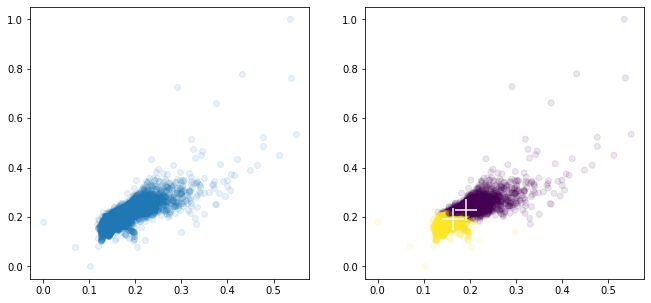

In [26]:
f, axes = plt.subplots(1, 2, figsize=(11,5))
axes[0].scatter(wrapper_top15[:,3], wrapper_top15[:,5], alpha=.1)
axes[1].scatter(wrapper_top15[:,3], wrapper_top15[:,5], c=fcm_labels, alpha=.1)
axes[1].scatter(fcm_centers[:,3], fcm_centers[:,5], marker="+", s=500, c='w')
# plt.savefig('basic-clustering-output.jpg')
plt.show()
#前一二分出的類別類內差距小且兩類的數量較平均(較符合生成假資料後的狀況)?

##fuzzy_c_means2


---
skfuzzy


     |████████████████████████████████| 1.0MB 7.5MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894069 sha256=526648d8a28119c82ed5017a731ddecc19dea1a6751f6f4d59afa860fd37ac6c
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy
[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


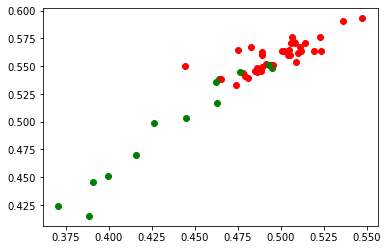

In [27]:
!pip install scikit-fuzzy
from skfuzzy.cluster import cmeans
train = wrapper_top15.T

center, u, u0, d, jm, p, fpc = cmeans(train, m=2, c=2, error=0.005, maxiter=1000)
for i in u:

  label = np.argmax(u, axis=0)

  print(label)


for i in range(50):

  if label[i] == 0:

    plt.scatter(train[0][i], train[1][i], c='r')

  elif label[i] == 1:

    plt.scatter(train[0][i], train[1][i], c='g')



plt.show()
#紅色類別較分散,綠色類別較集中(以第一二特徵也許綠色類能很好的分類,但紅色的不是很好估計?)

#層級分群


---
依照資料點間距離依序分群,再以指定的群數切割  
Single Linkage, Complete Linkage, and Average Linkage Clustering Algorithms 
不同距離計算方式會影響建立階層的順序

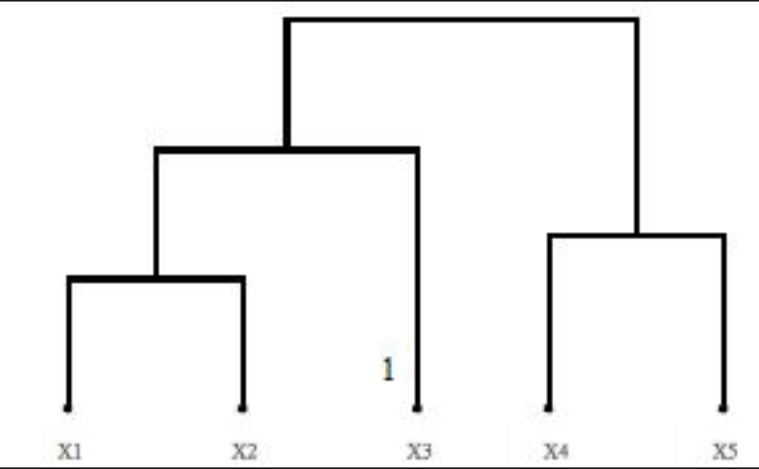

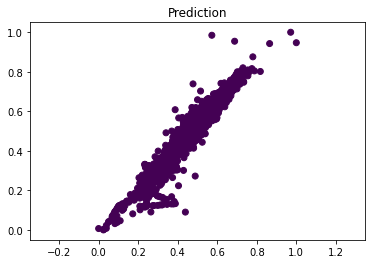

In [28]:
from sklearn.cluster import AgglomerativeClustering
n=2
#Agglomerative Clustering method
model = AgglomerativeClustering(n_clusters = n, linkage = 'single')
model.fit(wrapper_top15)
labels = model.fit_predict(wrapper_top15)
#results visualization
plt.figure()
plt.scatter(wrapper_top15[:,0], wrapper_top15[:,1], c = labels)
plt.axis('equal')
plt.title('Prediction')
plt.show()
#應該是上下重疊

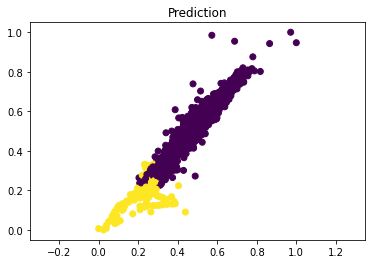

In [29]:
n=2
#Agglomerative Clustering method
model = AgglomerativeClustering(n_clusters = n, linkage = 'complete')
model.fit(wrapper_top15)
labels = model.fit_predict(wrapper_top15)
#results visualization
plt.figure()
plt.scatter(wrapper_top15[:,0], wrapper_top15[:,1], c = labels)
plt.axis('equal')
plt.title('Prediction')
plt.show()

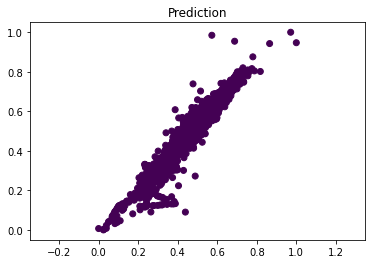

In [30]:
from sklearn.cluster import AgglomerativeClustering
n=2
#Agglomerative Clustering method
model = AgglomerativeClustering(n_clusters = n, linkage = 'average')
model.fit(X_train)
labels = model.fit_predict(wrapper_top15)
#results visualization
plt.figure()
plt.scatter(wrapper_top15[:,0], wrapper_top15[:,1], c = labels)
plt.axis('equal')
plt.title('Prediction')
plt.show()
#啥米情況??
#上下重疊again

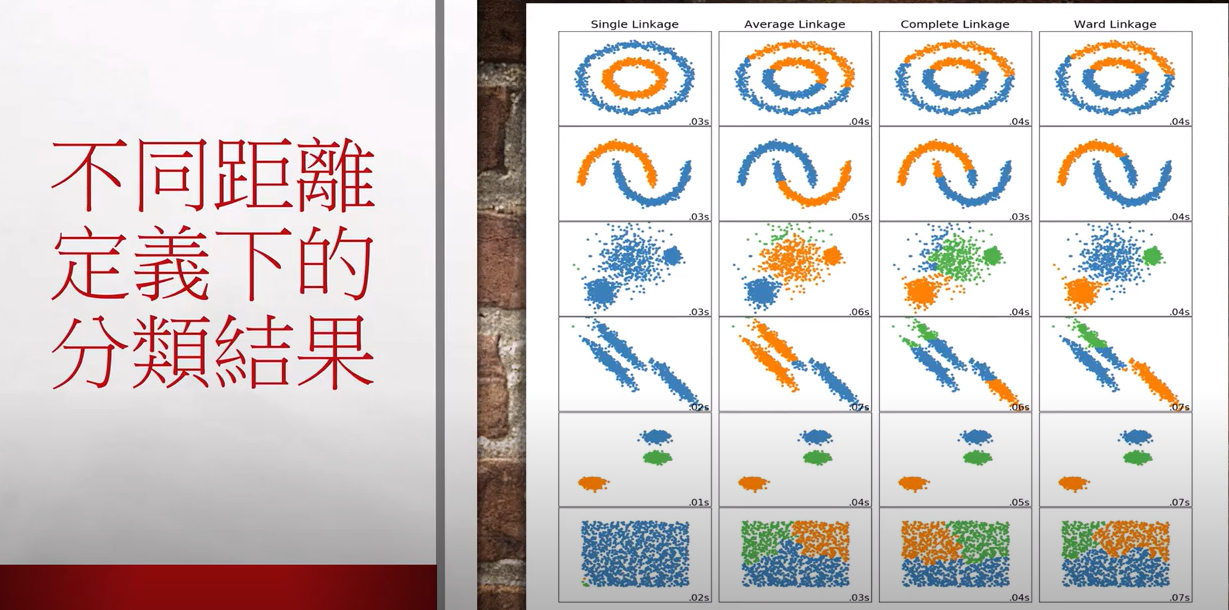

[kmeans](https://alankrantas.medium.com/kmeans-%E8%83%BD%E5%BE%9E%E8%B3%87%E6%96%99%E4%B8%AD%E6%89%BE%E5%87%BA-k-%E5%80%8B%E5%88%86%E9%A1%9E%E7%9A%84%E9%9D%9E%E7%9B%A3%E7%9D%A3%E5%BC%8F%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E6%BC%94%E7%AE%97%E6%B3%95-%E6%89%80%E4%BB%A5%E5%AE%83%E5%88%B0%E5%BA%95%E6%9C%89%E5%95%A5%E7%94%A8-%E4%BD%BF%E7%94%A8-scikit-learn-%E8%88%87-python-5dd8c0c8b167)

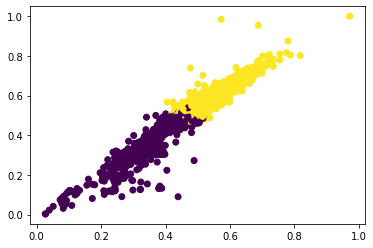

In [31]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=2,init='random',random_state=5)
dx ,dy =X_train,y_train
KM.fit(dx)
KM.predict(dx)
plt.scatter(dx[:,0],dx[:,1],c=KM.predict(dx))

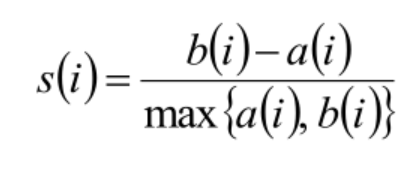
 
**silhouette :**  
(群外不相似度-群內不相似度)/max(群內,群外不相似度),越大越好表示群內相近群外差異大


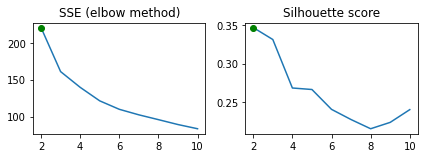

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
clusters =10
# K 值的範圍 (2~10)
k_range = range(2, clusters + 1)
dx, dy = X_train,y_train
distortions = []
scores = []
# 記錄每種 K 值建出的 KMeans 模型的成效
for i in k_range:
    kmeans = KMeans(n_clusters=i).fit(dx)
    distortions.append(kmeans.inertia_) # 誤差平方和 (SSE)
    scores.append(silhouette_score(dx, kmeans.predict(dx))) # 側影係數
# 找出最大的側影係數來決定 K 值
# 因為index編號從0開始,而群是從2開始所以加2
selected_K = scores.index(max(scores)) + 2
# 重新建立 KMeans 模型並預測目標值
kmeans = KMeans(n_clusters=selected_K).fit(dx)
new_dy = kmeans.predict(dx)

# 繪製誤差平方和圖 (手肘法)
plt.subplot(223)
plt.title('SSE (elbow method)')
plt.plot(k_range, distortions)
plt.plot(selected_K, distortions[selected_K - 2], 'go') # 最佳解
# 繪製係數圖
plt.subplot(224)
plt.title('Silhouette score')
plt.plot(k_range, scores)
plt.plot(selected_K, scores[selected_K - 2], 'go') # 最佳解
plt.tight_layout()
plt.show()
#怪怪der應該是sse最小,silhouette最高
#大概是群內外差距都大,而分越少群群間差異越大,所以有最高silhouette(但其實也很低)

https://alankrantas.medium.com/kmeans-%E8%83%BD%E5%BE%9E%E8%B3%87%E6%96%99%E4%B8%AD%E6%89%BE%E5%87%BA-k-%E5%80%8B%E5%88%86%E9%A1%9E%E7%9A%84%E9%9D%9E%E7%9B%A3%E7%9D%A3%E5%BC%8F%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E6%BC%94%E7%AE%97%E6%B3%95-%E6%89%80%E4%BB%A5%E5%AE%83%E5%88%B0%E5%BA%95%E6%9C%89%E5%95%A5%E7%94%A8-%E4%BD%BF%E7%94%A8-scikit-learn-%E8%88%87-python-5dd8c0c8b167